In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 23 10:08:49 2020

@author: USER
"""

import os,sys,re
import glob
import pandas as pd
import scipy.io
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import math
import tifffile as tiff
import tensorflow as tf
import pickle#save multiple variables into a pickle file
import func_get_data as fx


'''
user-specified input arguments
'''
version_name = 'v11'
input_dir = 'F:/emb_data'
folder_idx = 0

#use the below arguments and save different csv file
use_predict_tif = False #(False):use true labels tif . (True or has_processed=False): use predict.tif 
#default is to plot tp emb.
plot_fn = True #(TRUE):plot fn emb. from false_positive_index.txt 
plot_fp = False 
inv_c = True #stem curved like inverse of letter C or not

'''
Paths
'''
disk_path = os.path.join(input_dir,version_name)
all_folders_name = np.sort(os.listdir(disk_path))

all_folders_dir = [os.path.join(disk_path,folder) for folder in all_folders_name]

dir_path = all_folders_dir[folder_idx]
folder_name_short = all_folders_name[folder_idx]#Alclat2_stem



#output folder name based on user-specified arguments
if use_predict_tif:
    folder_tag1 = 'pred_tif'
else:
    folder_tag1= 'true_tif'

if plot_fn:
    folder_tag2 = 'has_fn'
else:
    folder_tag2 = 'no_fn'

if plot_fp:
    folder_tag3 = 'has_fp'
else:
    folder_tag3 = 'no_fp'

input_folder_tag = '_'.join((folder_tag1,folder_tag2,folder_tag3))
input_folder = os.path.join(dir_path,input_folder_tag)


In [2]:

'''
Load pickle data from get_data.py
'''
pickle_dict = pickle.load(open(os.path.join(input_folder,'shinydata.pkl'),"rb"))#dictionary
#pickle_dict.keys()
#Out[13]: dict_keys(['num_imgs', 'row_num', 'col_num', 'date_time_list', 'diff_time_list_int', 'embolism_table', 'plot_mat_all', 'plot_tiff', 'plot_mat_time'])
num_imgs = pickle_dict['num_imgs']
row_num = pickle_dict['row_num']
col_num = pickle_dict['col_num']
plot_mat_time = pickle_dict['plot_mat_time']

cc_emb_info = plot_mat_time.drop(['row','col'], axis = 1)#drop two columns that are of pixel level (smaller than cc level)
cc_emb_info = cc_emb_info.drop_duplicates()#keep unique rows
#cc_emb_info.columns
#Out[19]: 
#Index(['number_emb', 'cc_num_emb', 'cc_width', 'cc_height', 'cc_area',
#       'cc_centroid_row', 'cc_centroid_col', 'embolism_time',
#       'time_since_start(mins)'],
#      dtype='object')

pt_mat_upright = fx.get_upright_mat(plot_mat_time, row_num,col_num,inv_c)


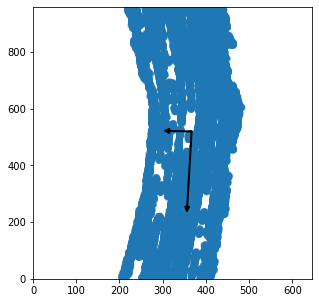

In [3]:
'''
use PCA to adjust for tiltness to get more accurate cc width and cc height and centroids
'''
#what happens when do PCA on all emoblism in this folder
#stem might have curve...:(
X = plot_mat_time[['col','row']].to_numpy()#extract only pixel position columns. have to be this order ['col','row'] so that when doing PCA the order would be the same as (x,y)
pca = fx.do_pca(X, row_num, col_num, to_plot=True)

cc_emb_info_upright = pt_mat_upright.drop(['row','col'], axis = 1)#drop two columns that are of pixel level (smaller than cc level)
cc_emb_info_upright = cc_emb_info_upright.drop_duplicates()#keep unique rows


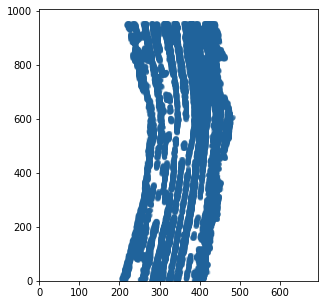

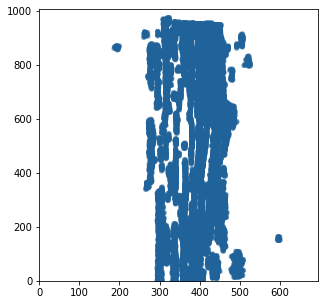

In [4]:
'''
See the effects after adjusting for tiltness
'''
#plot out all embolism in this folder, can see that stem might have curves --> cc might be tilted
fx.plot_point(plot_mat_time,xlim = col_num+50, ylim = row_num+50)

#plot out all embolism in this folder
fx.plot_point(pt_mat_upright,xlim = col_num+50, ylim = row_num+50)

646 958
cc width before adjusting tiltness =  67.0
cc width after adjusting tiltness =  18.118775935075746


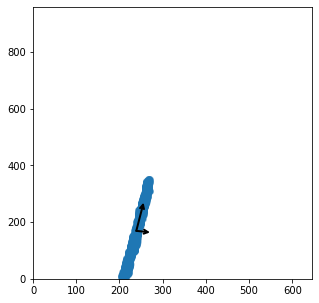

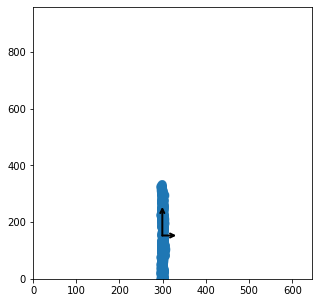

In [5]:
print(col_num,row_num)
#plot out on specific embolism event to see the effect of adjusting for tiltness
cc_index = 75
df_cc_index = plot_mat_time[plot_mat_time.cc_num_emb==cc_index]
X_cc_i = df_cc_index[['col','row']].to_numpy()#extract only pixel position columns. have to be this order ['col','row'] so that when doing PCA the order would be the same as (x,y)
fx.do_pca(X_cc_i, row_num, col_num, to_plot=True)

df_cc_index_upright = pt_mat_upright[pt_mat_upright.cc_num_emb==cc_index]
X_cc_i_upright = df_cc_index_upright[['col','row']].to_numpy()#extract only pixel position columns. have to be this order ['col','row'] so that when doing PCA the order would be the same as (x,y)
fx.do_pca(X_cc_i_upright, row_num, col_num, to_plot=True)

#fx.plot_point_one_emb_or_one_img(plot_mat_time,row_num,col_num,cc_num_emb=cc_index,fig_size=5)
print("cc width before adjusting tiltness = ",np.unique(cc_emb_info[cc_emb_info.cc_num_emb==cc_index]['cc_width'])[0])
#fx.plot_point_one_emb_or_one_img(pt_mat_upright,row_num,col_num,cc_num_emb=cc_index,fig_size=5)
print("cc width after adjusting tiltness = ",np.unique(cc_emb_info_upright[cc_emb_info_upright.cc_num_emb==cc_index]['cc_width'])[0])

# pca_explained variance is strongly correlated with cc size
#ggplot(cc_emb_info_upright, aes(y='cc_area', x='pca_explained_var1'))+geom_point()


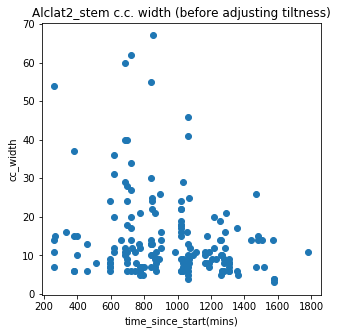

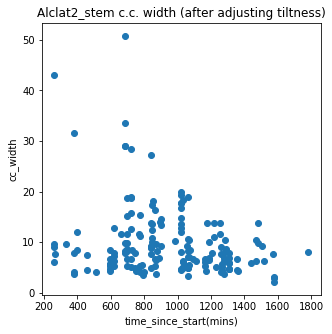

max cc width change: 48.881224064924254
cc width decreases at most: 48.881224064924254  pixels
cc width increases at most: 0.8604493030185267  pixels


In [6]:
'''
change in cc width after adjusting for tiltness 
'''
#after adjusting for tiltness, cc width becomes smaller
fx.scatter_plt(cc_emb_info,y='cc_width',x='time_since_start(mins)',title_str=str(folder_name_short)+" c.c. width (before adjusting tiltness)",fig_size=5)
fx.scatter_plt(cc_emb_info_upright,y='cc_width',x='time_since_start(mins)',title_str=str(folder_name_short)+" c.c. width (after adjusting tiltness)")
print("max cc width change:",max(abs(cc_emb_info['cc_width']-cc_emb_info_upright['cc_width'])))
print("cc width decreases at most:",max(cc_emb_info['cc_width']-cc_emb_info_upright['cc_width'])," pixels")
print("cc width increases at most:",max(cc_emb_info_upright['cc_width']-cc_emb_info['cc_width'])," pixels")

In [7]:
'''
change in cc height after adjusting for tiltness 
'''
#height doesn't change that much, just slightly
#fx.scatter_plt(cc_emb_info,y='cc_height',x='time_since_start(mins)',title_str=str(folder_name_short)+" c.c. height (before adjusting tiltness)")
#fx.scatter_plt(cc_emb_info_upright,y='cc_height',x='time_since_start(mins)',title_str=str(folder_name_short)+" c.c. height (after adjusting tiltness)")
print("max cc height change:",max(abs(cc_emb_info['cc_height']-cc_emb_info_upright['cc_height'])))

max cc height change: 4.744511046305661


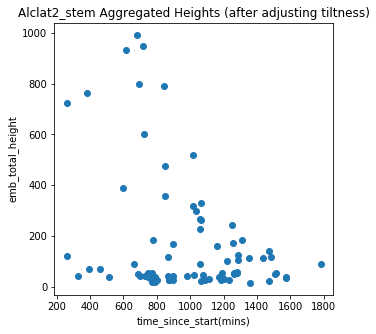

In [8]:
'''
aggregated height in one differenced image with embolism event(s)
embolism height: long --> short over time
'''
cc_emb_total_height = cc_emb_info_upright.groupby(['number_emb','time_since_start(mins)'])['cc_height'].sum().reset_index()
cc_emb_total_height = cc_emb_total_height.rename(columns = {'cc_height':'emb_total_height'})

#sum up all the c.c. height for each num_emb (i.e. for 1 differenced image)
fx.scatter_plt(cc_emb_total_height,y='emb_total_height',x='time_since_start(mins)',title_str=str(folder_name_short)+" Aggregated Heights (after adjusting tiltness)")

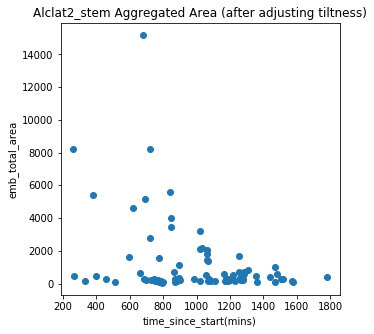

In [9]:
'''
aggregated height in one differenced image with embolism event(s)
embolism height: long --> short over time
'''
cc_emb_total_area = cc_emb_info_upright.groupby(['number_emb','time_since_start(mins)'])['cc_area'].sum().reset_index()
cc_emb_total_area = cc_emb_total_area.rename(columns = {'cc_area':'emb_total_area'})
#print(cc_emb_total_area) #80 x 3
#sum up all the c.c. height for each num_emb (i.e. for 1 differenced image)
fx.scatter_plt(cc_emb_total_area,y='emb_total_area',x='time_since_start(mins)',title_str=str(folder_name_short)+" Aggregated Area (after adjusting tiltness)")

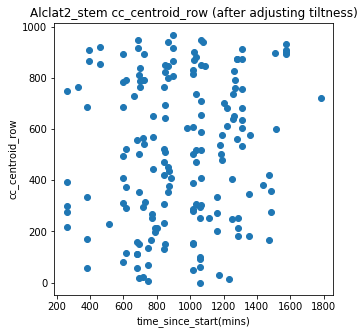

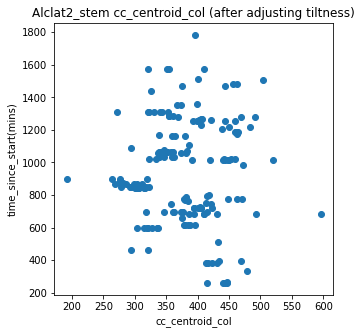

In [10]:
'''
cc centroid after adjusting tiltness
'''
fx.scatter_plt(cc_emb_info_upright,y='cc_centroid_row',x='time_since_start(mins)',title_str=str(folder_name_short)+" cc_centroid_row (after adjusting tiltness)")
fx.scatter_plt(cc_emb_info_upright,x='cc_centroid_col',y='time_since_start(mins)',title_str=str(folder_name_short)+" cc_centroid_col (after adjusting tiltness)")


mean of cc_centroid_col:  390.3167472442657


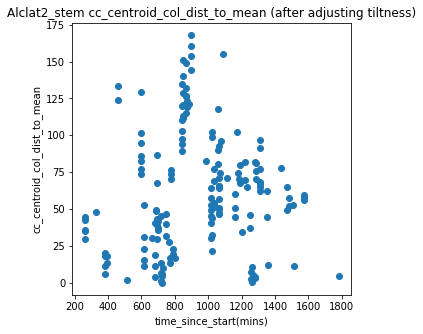

In [11]:
x_mean = np.mean(pt_mat_upright['col'])
print("mean of cc_centroid_col: ", x_mean)
cc_centroid_col_dist_to_mean = cc_emb_info['cc_centroid_col'].apply(lambda x: abs(x - x_mean))
cc_centroid_col_dist_to_mean = pd.concat([cc_centroid_col_dist_to_mean.reset_index(drop=True),cc_emb_info['time_since_start(mins)'].reset_index(drop=True)],axis=1)
cc_centroid_col_dist_to_mean = cc_centroid_col_dist_to_mean.rename(columns = {'cc_centroid_col':'cc_centroid_col_dist_to_mean'})
#print(cc_centroid_col_dist_to_mean)
fx.scatter_plt(cc_centroid_col_dist_to_mean,y='cc_centroid_col_dist_to_mean',x='time_since_start(mins)',title_str=str(folder_name_short)+" cc_centroid_col_dist_to_mean (after adjusting tiltness)",fig_size=5)


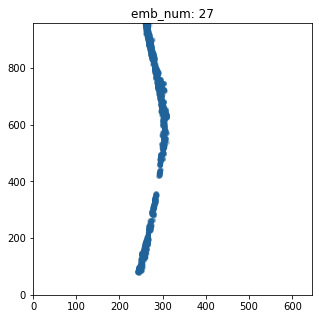

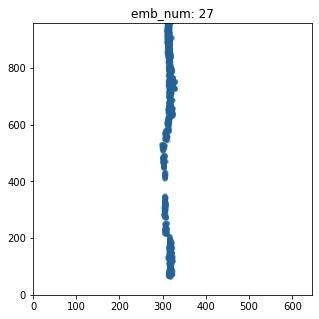

In [12]:
#take a look at when there are multiple cc in the same time --> seem to be artifact of how I adjusted tiltness
#time_min = 820
#time_max = 850
#print(cc_emb_info_upright[(cc_emb_info_upright['time_since_start(mins)']>time_min) & (cc_emb_info_upright['time_since_start(mins)']<time_max)])
num_emb_i = 27
#print(cc_emb_info_upright[cc_emb_info_upright.number_emb==num_emb_i])
fx.plot_point_one_emb_or_one_img(plot_mat_time,row_num,col_num,cc_num_emb=-1,num_emb=num_emb_i,fig_size=5)#before adjusting tiltness
fx.plot_point_one_emb_or_one_img(pt_mat_upright,row_num,col_num,cc_num_emb=-1,num_emb=num_emb_i,fig_size=5)#after adjusting tiltness


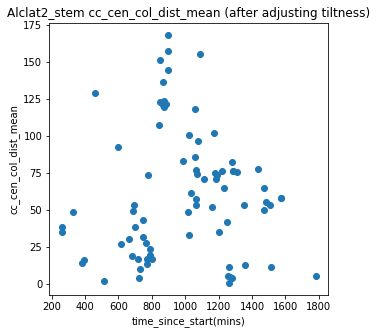

In [13]:
'''
Take the mean of cc_centroid_col_dist_to_mean in each differenced image
centroid x location: away --> center --> away --> center 
'''
cc_col_dist_mean = cc_centroid_col_dist_to_mean.groupby(['time_since_start(mins)'])['cc_centroid_col_dist_to_mean'].mean().reset_index()
cc_col_dist_mean = cc_col_dist_mean.rename(columns = {'cc_centroid_col_dist_to_mean':'cc_cen_col_dist_mean'})

#sum up all the c.c. height for each num_emb (i.e. for 1 differenced image)
fx.scatter_plt(cc_col_dist_mean,y='cc_cen_col_dist_mean',x='time_since_start(mins)',title_str=str(folder_name_short)+" cc_cen_col_dist_mean (after adjusting tiltness)")